## Harjoitustyö



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
!pip install scrapy

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached Scrapy-2.5.0-py2.py3-none-any.whl (254 kB)
Processing /root/.cache/pip/wheels/dc/d0/bf/0cc715c01fce0bace63b46283acf5cc630d5e5dbb4602c54e5/PyDispatcher-2.0.5-py3-none-any.whl
  Using cached zope.interface-5.4.0-cp37-cp37m-manylinux2010_x86_64.whl (251 kB)
Processing /root/.cache/pip/wheels/ca/44/01/3592ccfbcfaee4ab297c4097e6e9dbe1c7697e3531a39877ab/Protego-0.1.16-py3-none-any.whl
  Using cached w3lib-1.22.0-py2.py3-none-any.whl (20 kB)
  Using cached service_identity-18.1.0-py2.py3-none-any.whl (11 kB)
  Using cached itemadapter-0.2.0-py3-none-any.whl (9.3 kB)
  Using cac

In [2]:
!scrapy genspider etuovi_scraper etuovi.com

/root/joda/etuovi_scraper.py already exists


In [2]:
## lopullinen raapija

import scrapy
# raapija, joka kerää etuovi.com:sta ilmoituksien tiedoista
# asuntotyypin, osoitteen, hinnan, valmistuvuoden ja pinta-alan.
# (Kyseessä Tampereen omakotitalot)
class EtuoviScraperSpider(scrapy.Spider):
    name = 'etuovi_scraper'
    allowed_domains = ['etuovi.com']
    # assing a page url below
    start_urls = \
    ['https://www.etuovi.com/myytavat-asunnot?haku=M1644983732&sivu=0']

  # Funkito parse(self, response) käy läpi aloitusosoitteesta eteenpäin
  # sivuja, joilta dataa kerätään. Parse kutsuu parse_page-funktiota, jossa
  # on määritelty varsinainen kerättävä tieto.
  # max 5 sivua tässä esimerkissä
    def parse(self, response):
        for i in range(1, 21):
            url=response.request.url[:-1]+str(i)
            yield scrapy.Request(url, callback=self.parse_page)
        
    
    def parse_page(self, response):
        description_texts = response.css(\
          '[class="flexboxgrid__col-xs-12__1I1LS"] *::text').extract()
        size_text = response.css(\
          '[class="flexboxgrid__col-xs__26GXk flexboxgrid__col-md-4__2DYW-"] > span::text').extract()
        year_text = response.css(\
          '[class="flexboxgrid__col-xs-3__3Kf8r flexboxgrid__col-md-4__2DYW-"] > span::text'\
          ).extract()
        price_text = response.css('[class="flexboxgrid__col-xs-4__p2Lev flexboxgrid__col-md-4__2DYW-"] > span:first-of-type::text').extract()

        for i in range(len(price_text)):
            yield {
                'house_type' : description_texts[2*i],
                'address': description_texts[2*i+1],
                'price': price_text[i],
                'year': year_text[i],
                'size': size_text[i]
            }

In [4]:
!scrapy runspider etuovi_scraper.py -o TreTurkuJklOulu.json

2021-04-27 18:24:03 [scrapy.utils.log] INFO: Scrapy 2.5.0 started (bot: scrapybot)
2021-04-27 18:24:03 [scrapy.utils.log] INFO: Versions: lxml 4.6.3.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 21.2.0, Python 3.7.10 (default, Feb 26 2021, 18:47:35) - [GCC 7.3.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1k  25 Mar 2021), cryptography 3.4.7, Platform Linux-4.14.225-169.362.amzn2.x86_64-x86_64-with-debian-10.6
2021-04-27 18:24:03 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.epollreactor.EPollReactor
2021-04-27 18:24:03 [scrapy.crawler] INFO: Overridden settings:
{'SPIDER_LOADER_WARN_ONLY': True}
2021-04-27 18:24:03 [scrapy.extensions.telnet] INFO: Telnet Password: 96d63d716a85eefc
2021-04-27 18:24:03 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.logstats.LogStats']
202

In [29]:
!git commit -m "data collection modified, data cleaning and visualization added"

[master 78d89c4] data collection modified, data cleaning and visualization added
 1 file changed, 2072 insertions(+), 135 deletions(-)


In [28]:
!git add 'joda_ht.ipynb'

In [2]:
!git config --global user.email "sara.paukkeri@hotmail.com"

## Datan siivoaminen ja piirteiden  muokkaus

In [3]:
import json

In [4]:
# read TreTurkuJklOulu.json file to d
d = open('TreTurkuJklOulu.json')
#d = open('out2.json') #whole dataset
data = json.load(d)
d.close()
data[0:1]

[{'house_type': 'Erillistalo | 5h + k + s',
  'address': 'Kirkkosalmenkaarre 18 A 3, Oulunsalo, Oulu',
  'price': '236\xa0400\xa0€',
  'year': '2021',
  'size': '105 m²'}]

In [5]:
# convert array to dataframe
df = pd.DataFrame(data)
df.head()

,house_type,address,price,year,size
0,Erillistalo | 5h + k + s,"Kirkkosalmenkaarre 18 A 3, Oulunsalo, Oulu",236 400 €,2021,105 m²
1,"Omakotitalo | 4h, k, kh. 3h, k, kh. 2x2h, k, k...","Puolangantie 554, Ylikiiminki, Oulu",149 000 €,1952,430 / 522 m²
2,Omakotitalo | 3H + K + KPH + S + Aula + Takkah...,"Sepänkuja 8, Kiiminki, Oulu",129 000 €,1976,120 / 150 m²
3,Omakotitalo | 4h + k + sa + tuulikaappi + at,"Taurinkuja 21, Peltola, Oulu",179 000 €,-,109 / 144 m²
4,"Omakotitalo | 3-4h, k, kph, s","Hietatie 34, Keljonkangas, Jyväskylä",139 000 €,1963,96 / 130 m²


In [6]:
# split column size to size and living_space and remove "m2" and spaces
# add rows with empty values(="-") to remove
remove=[]
living_space=[]

for i in range(0, df['size'].size):
  
    if "/" in df['size'][i]: 
        sizes = df.loc[i,'size'].split("/")
        df.loc[i,'size'] = sizes[1].replace(" ", "").replace("m\u00b2","").replace(",",".").replace("\xa0", "")
        living_space.append(sizes[0].replace(" ", "").replace(",",".").replace("\xa0", ""))
    elif df['size'][i] != "-": #  only one size available
        df.loc[i,'size'] = df.loc[i,'size'].replace(" ", "").replace("m\u00b2","").replace(",",".").replace("\xa0", "")
        living_space.append(df.loc[i,'size'])
    else: # size is "-" or
        living_space.append(0)
        remove.append(i)
        df.loc[i,'size']=None
  
df['living_space']=living_space

df['size'] = df['size'].astype(float)
df.living_space = df.living_space.astype(float)

In [7]:
# remove € from price and set datatype to int
for i in range(0, df['price'].size): #=0; i < df.price.length; i++):
    #df['price'][i]=price.replace("-","")
    if float(df.loc[i,'price'].replace("\xa0", "").replace('€',"").replace(",","."))>=float(1000000):#####################################
        remove.append(i)#####################################################
        df.loc[i,'price']=None######################
    elif (df.loc[i,'price']=='-') and (i not in remove):
        remove.append(i)
        df.loc[i,'price']=None
    else: 
        df.loc[i,'price'] = df.loc[i,'price'].replace("\xa0", "").replace('€',"").replace(",",".")

df['price'] = df['price'].astype(float)

In [8]:
df.head()

,house_type,address,price,year,size,living_space
0,Erillistalo | 5h + k + s,"Kirkkosalmenkaarre 18 A 3, Oulunsalo, Oulu",236400.0,2021,105.0,105.0
1,"Omakotitalo | 4h, k, kh. 3h, k, kh. 2x2h, k, k...","Puolangantie 554, Ylikiiminki, Oulu",149000.0,1952,522.0,430.0
2,Omakotitalo | 3H + K + KPH + S + Aula + Takkah...,"Sepänkuja 8, Kiiminki, Oulu",129000.0,1976,150.0,120.0
3,Omakotitalo | 4h + k + sa + tuulikaappi + at,"Taurinkuja 21, Peltola, Oulu",179000.0,-,144.0,109.0
4,"Omakotitalo | 3-4h, k, kph, s","Hietatie 34, Keljonkangas, Jyväskylä",139000.0,1963,130.0,96.0


In [9]:
# Split address to address, region, area
area=[]
city=[]

for i in range(0, df['address'].size):
    add = df.loc[i,'address'].split(", ")
    df.loc[i,'address'] = add[0]
    if len(add) < 3:
        add2 = add[1].split(" ")
        if len(add2) < 2:
            city.append(add2[0])
            area.append(add2[0])
        else:
            city.append(add2[1])
            area.append(add2[0])
    else:
        area.append(add[1])
        city.append(add[2])
  
df['area']=area
df['city'] = city

In [10]:
rooms=[]

for i in range(0, df['house_type'].size):
    house = df.loc[i,'house_type'].split(" | ")
    if len(house) < 2: #only another information available
        df.loc[i,'house_type'] = house[0]
        rooms.append(house[0])
    else:
        df.loc[i,'house_type'] = house[0]
        rooms.append(house[1])
  
df['rooms']=rooms

In [11]:
for i in range(0, df.year.size):
    if df.loc[i,'year']=="-" and i not in remove:
        remove.append(i)

df = df.drop(remove)

df['year'] = df['year'].astype(int)

In [12]:
df.head()

,house_type,address,price,year,size,living_space,area,city,rooms
0,Erillistalo,Kirkkosalmenkaarre 18 A 3,236400.0,2021,105.0,105.0,Oulunsalo,Oulu,5h + k + s
1,Omakotitalo,Puolangantie 554,149000.0,1952,522.0,430.0,Ylikiiminki,Oulu,"4h, k, kh. 3h, k, kh. 2x2h, k, kh. Kerhotila"
2,Omakotitalo,Sepänkuja 8,129000.0,1976,150.0,120.0,Kiiminki,Oulu,3H + K + KPH + S + Aula + Takkahuone + VH + Va...
4,Omakotitalo,Hietatie 34,139000.0,1963,130.0,96.0,Keljonkangas,Jyväskylä,"3-4h, k, kph, s"
5,Erillistalo,Korttitie 20 B,420000.0,2021,119.5,110.5,Pateniemi,Oulu,4mh + oh + k + khh + wc + ph + s


Muokataan osoite koordinaateiksi

In [14]:
!pip install geopy

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [13]:
# edit the address to a format suitable for the coordinate change
df['geo_address'] = df["address"]+ ", " + df["city"] + ", Finland"

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = "joda ht")


In [14]:
df["loc"] = df["geo_address"].apply(geolocator.geocode)
# select koordinates from loc
df["point"] = df["loc"].apply(lambda loc: tuple(loc.point) if loc else None)
#split coordinates to latitude, longitude and altitude
df[['lat', 'lon', 'altitude']] = pd.DataFrame(df['point'].to_list(), index=df.index)

In [161]:
import haversine as hs

#coordinates of city centers

j = {'Kaupunki': ['Tampere', 'Oulu', 'Jyväskylä', 'Turku'], 'Osoite': ['Keskustori 1, Tampere, Finland',  \
    'Kauppatori, Oulu, Finland', 'Asema-aukio, Jyväskylä, Finland', 'Eerikinkatu, Turku, Finland']}
city_center = pd.DataFrame(j)


city_center["loc"] = city_center["Osoite"].apply(geolocator.geocode)
# select koordinates from loc
city_center["point"] = city_center["loc"].apply(lambda loc: tuple(loc.point) if loc else None)
#split coordinates to latitude, longitude and altitude
city_center[['lat', 'lon', 'altitude']] = pd.DataFrame(city_center["point"].to_list(), index=city_center.index)

city_center.head()

,Kaupunki,Osoite,loc,point,lat,lon,altitude
0,Tampere,"Keskustori 1, Tampere, Finland","(Keskustori I, Jugendtori, Tammerkoski, Ratina...","(61.4973936, 23.7607905, 0.0)",61.497394,23.760790,0.0
1,Oulu,"Kauppatori, Oulu, Finland","(Kauppatori, Kaarlenväylä, Ydinkeskusta, Pokki...","(65.0142385, 25.4654655, 0.0)",65.014239,25.465466,0.0
2,Jyväskylä,"Asema-aukio, Jyväskylä, Finland","(Asema-aukio, 1. kaupunginosa, Kantakaupunki, ...","(62.2412309, 25.7496762, 0.0)",62.241231,25.749676,0.0
3,Turku,"Eerikinkatu, Turku, Finland","(Eerikinkatu, Tervatori, VI, Keskusta, Turku, ...","(60.4534928, 22.2747381, 0.0)",60.453493,22.274738,0.0


In [162]:
#calcute distances from city centers
distances = []
for index, row in df.iterrows():
    if 'Tampere' in row.city:
        if hs.haversine((city_center['lat'][0],city_center['lon'][0]),(row['lat'],row['lon'])) >200:
            distances.append(None)
        else:
            distances.append(hs.haversine((city_center['lat'][0],city_center['lon'][0]),(row['lat'],row['lon'])))
    elif 'Oulu' in row.city:
        if hs.haversine((city_center['lat'][1],city_center['lon'][1]),(row['lat'],row['lon'])) >200:
            distances.append(None)
        else:
            distances.append(hs.haversine((city_center['lat'][1],city_center['lon'][1]),(row['lat'],row['lon'])))
    elif 'Jyväskylä' in row.city:
        if hs.haversine((city_center['lat'][2],city_center['lon'][2]),(row['lat'],row['lon'])) >200:
            distances.append(None)
        else:
            distances.append(hs.haversine((city_center['lat'][2],city_center['lon'][2]),(row['lat'],row['lon'])))
    elif 'Turku' in row.city:
        if hs.haversine((city_center['lat'][3],city_center['lon'][3]),(row['lat'],row['lon'])) >200:
            distances.append(None)
        else:
            distances.append(hs.haversine((city_center['lat'][3],city_center['lon'][3]),(row['lat'],row['lon'])))
    else:
        distances.append(None)

df['distance']=distances

In [17]:
df.head()

,house_type,address,price,year,size,living_space,area,city,rooms,geo_address,loc,point,lat,lon,altitude,distance
0,Erillistalo,Kirkkosalmenkaarre 18 A 3,236400.0,2021,105.0,105.0,Oulunsalo,Oulu,5h + k + s,"Kirkkosalmenkaarre 18 A 3, Oulu, Finland","(Kirkkosalmenkaarre, Oulunsalo, Oulu, Oulun se...","(64.9293039, 25.4216705, 0.0)",64.929304,25.421671,0.0,9.666413
1,Omakotitalo,Puolangantie 554,149000.0,1952,522.0,430.0,Ylikiiminki,Oulu,"4h, k, kh. 3h, k, kh. 2x2h, k, kh. Kerhotila","Puolangantie 554, Oulu, Finland","(Puolangantie, Jokela, Oulu, Oulun seutukunta,...","(64.9804365, 26.2247937, 0.0)",64.980436,26.224794,0.0,35.883887
2,Omakotitalo,Sepänkuja 8,129000.0,1976,150.0,120.0,Kiiminki,Oulu,3H + K + KPH + S + Aula + Takkahuone + VH + Va...,"Sepänkuja 8, Oulu, Finland","(Sepänkuja, Raatinharju, Kolamäki, Kiiminki, O...","(65.1255237, 25.7875678, 0.0)",65.125524,25.787568,0.0,19.520298
4,Omakotitalo,Hietatie 34,139000.0,1963,130.0,96.0,Keljonkangas,Jyväskylä,"3-4h, k, kph, s","Hietatie 34, Jyväskylä, Finland","(34, Hietatie, Keljonkangas, Jyväskylä, Jyväsk...","(62.190388049999996, 25.714925560192444, 0.0)",62.190388,25.714926,0.0,5.933479
5,Erillistalo,Korttitie 20 B,420000.0,2021,119.5,110.5,Pateniemi,Oulu,4mh + oh + k + khh + wc + ph + s,"Korttitie 20 B, Oulu, Finland","(Korttitie, Pateniemi, Oulu, Oulun seutukunta,...","(65.0818715, 25.3939211, 0.0)",65.081872,25.393921,0.0,8.235307


### Datan kuvaileminen

Text(0.5, 1.0, 'Living Space')

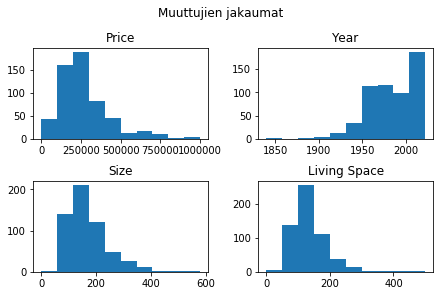

In [55]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 2)
fig.suptitle('Muuttujien jakaumat')

f_ax1 = fig.add_subplot(gs[0, 0])
f_ax1.hist(df['price'])
f_ax1.set_title('Price')
f_ax2 = fig.add_subplot(gs[0, 1])
f_ax2.hist(df['year'])
f_ax2.set_title('Year')
f_ax3 = fig.add_subplot(gs[1, 0])
f_ax3.hist(df['size'])
f_ax3.set_title('Size')
f_ax4 = fig.add_subplot(gs[1, 1])
f_ax4.hist(df['living_space'])
f_ax4.set_title('Living Space')

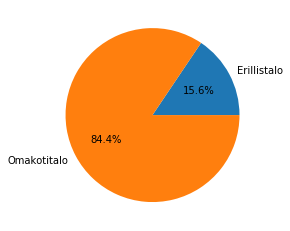

In [56]:
from collections import Counter

#type of houses in data
value = Counter(df['house_type']).values()
label = Counter(df['house_type']).keys()

plt.pie(value, labels = label, autopct='%1.1f%%')
plt.show()

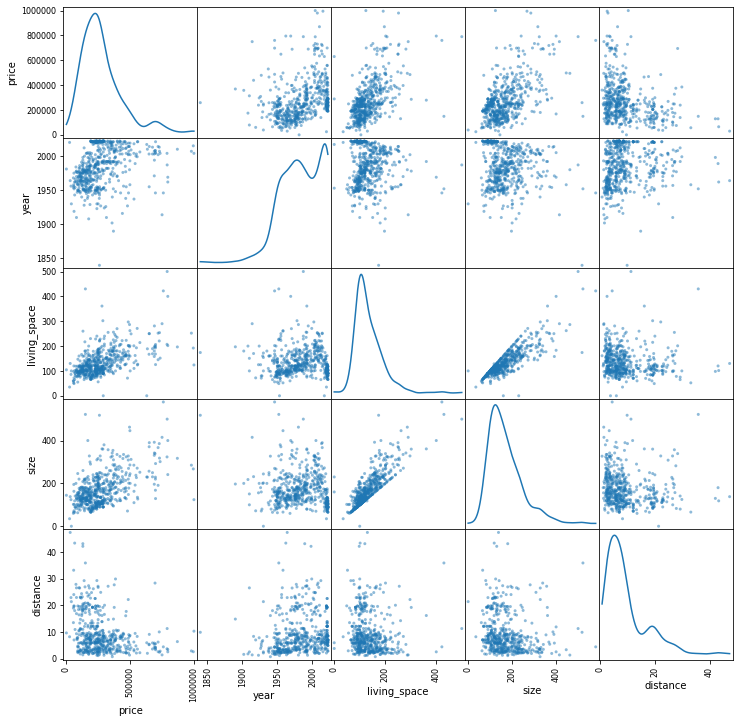

In [58]:
from pandas.plotting import scatter_matrix

# plot a scatter matrix to detect dependencies
df_int = df.loc[:,['price', 'year', 'living_space', 'size','distance']]

scatter_matrix(df_int, figsize=(12,12), diagonal="kde");

In [59]:
df.corr()

,price,year,size,living_space,lat,lon,altitude,distance
price,1.000000,0.300265,0.530428,0.547374,-0.278903,-0.275046,NaN,-0.303846
year,0.300265,1.000000,-0.153536,-0.035036,0.237919,0.152922,NaN,0.130424
size,0.530428,-0.153536,1.000000,0.846982,-0.283012,-0.190450,NaN,-0.135351
living_space,0.547374,-0.035036,0.846982,1.000000,-0.180483,-0.118483,NaN,-0.093630
lat,-0.278903,0.237919,-0.283012,-0.180483,1.000000,0.743172,NaN,0.298597
lon,-0.275046,0.152922,-0.190450,-0.118483,0.743172,1.000000,NaN,0.227138
altitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distance,-0.303846,0.130424,-0.135351,-0.093630,0.298597,0.227138,NaN,1.000000


In [67]:
!pip install folium

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 464 kB/s eta 0:00:011


In [18]:
import folium
from folium.plugins import MarkerCluster

#Define coordinates of where we want to center our map
center = [61.6027417, 23.8721711]

#Create the map
my_map = folium.Map(location = center, zoom_start = 5)

# Add addresses to the map
for index, row in df.iterrows():
    if row.point != None:
        text ="Price: " + str(row.price) + " €" + "\n Size: " + str(row['size']) + " m2 " + "Address: " + row.address
        folium.Marker([row.lat,row.lon], popup = text).add_to(my_map)

#Display the map
my_map

### Koneoppiminen

In [19]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

from sklearn.linear_model import LinearRegression # OLS algorithm
from sklearn.linear_model import Ridge # Ridge algorithm
from sklearn.linear_model import Lasso # Lasso algorithm
from sklearn.linear_model import BayesianRidge # Bayesian algorithm
from sklearn.linear_model import ElasticNet # ElasticNet algorithm
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import r2_score # evaluation metric

import os

In [121]:
#select features
#0=house_type, 1=address 2=price, 3=year,
#4=size, 5=living_space, 6=area, 7=city, 8=rooms
#15=distance #12=lat, 13=lon

dfTrain = df.iloc[:,[0,2,3,4,5,7,8,15,12,13]]

In [122]:
# Converting house_type attribute to categorical values.
le = preprocessing.LabelEncoder()

arr = le.fit_transform(dfTrain.house_type)
dfTrain['house_type_ec'] = arr

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [123]:
dfTrain

,house_type,price,year,size,living_space,city,rooms,distance,lat,lon,house_type_ec
0,Erillistalo,236400.0,2021,105.0,105.0,Oulu,5h + k + s,9.666413,64.929304,25.421671,0
1,Omakotitalo,149000.0,1952,522.0,430.0,Oulu,"4h, k, kh. 3h, k, kh. 2x2h, k, kh. Kerhotila",35.883887,64.980436,26.224794,1
2,Omakotitalo,129000.0,1976,150.0,120.0,Oulu,3H + K + KPH + S + Aula + Takkahuone + VH + Va...,19.520298,65.125524,25.787568,1
4,Omakotitalo,139000.0,1963,130.0,96.0,Jyväskylä,"3-4h, k, kph, s",5.933479,62.190388,25.714926,1
5,Erillistalo,420000.0,2021,119.5,110.5,Oulu,4mh + oh + k + khh + wc + ph + s,8.235307,65.081872,25.393921,0
...,...,...,...,...,...,...,...,...,...,...,...
595,Omakotitalo,159000.0,1968,207.7,99.7,Turku,4h + k + ruokailutila + wc + 2vh + s + ph + pu...,5.852514,60.458929,22.168568,1
596,Omakotitalo,530000.0,1937,110.0,110.0,Tampere,3mh + oh / k / rt + kuisti + wc + kph / wc / k...,2.875991,61.503266,23.708001,1
597,Erillistalo,425000.0,2021,119.5,110.5,Oulu,4mh + oh + k + khh + wc + ph + s,8.235307,65.081872,25.393921,0
598,Omakotitalo,195000.0,1954,135.0,70.0,Tampere,4-5h + k + s,5.801826,61.472628,23.856991,1


In [125]:
#Data normalization: Min-Max-Scalar / RobustScaler
scaler = preprocessing.RobustScaler()
#scaler = preprocessing.MinMaxScaler() 

dfTrain = dfTrain.dropna()

#select features from data and normalize training features

dfTrain_scaled = pd.DataFrame(scaler.fit_transform(dfTrain.iloc[:, [10,2,3,4,7]]))
dfTrain_scaled['city']=np.array(dfTrain.iloc[:,[5]])
dfTrain_scaled['price']=np.array(dfTrain.iloc[:, [1]])
dfTrain_scaled['lat']=np.array(dfTrain.iloc[:,[8]])
dfTrain_scaled['lon']=np.array(dfTrain.iloc[:, [9]])
dfTrain_scaled['house_type']=np.array(dfTrain.iloc[:,[0]])
dfTrain_scaled['rooms']=np.array(dfTrain.iloc[:, [6]])
dfTrain_scaled['year']=np.array(dfTrain.iloc[:,[2]])
dfTrain_scaled['size']=np.array(dfTrain.iloc[:, [3]])
dfTrain_scaled['living_space']=np.array(dfTrain.iloc[:, [4]])


dfTrain_scaled.head()


,0,1,2,3,4,city,price,lat,lon,house_type,rooms,year,size,living_space
0,-1.0,0.886364,-0.560533,-0.290323,0.358990,Oulu,236400.0,64.929304,25.421671,Erillistalo,5h + k + s,2021,105.0,105.0
1,0.0,-0.681818,3.887467,4.951613,3.905836,Oulu,149000.0,64.980436,26.224794,Omakotitalo,"4h, k, kh. 3h, k, kh. 2x2h, k, kh. Kerhotila",1952,522.0,430.0
2,0.0,-0.136364,-0.080533,-0.048387,1.692078,Oulu,129000.0,65.125524,25.787568,Omakotitalo,3H + K + KPH + S + Aula + Takkahuone + VH + Va...,1976,150.0,120.0
3,0.0,-0.431818,-0.293867,-0.435484,-0.146022,Jyväskylä,139000.0,62.190388,25.714926,Omakotitalo,"3-4h, k, kph, s",1963,130.0,96.0
4,-1.0,0.886364,-0.405867,-0.201613,0.165382,Oulu,420000.0,65.081872,25.393921,Erillistalo,4mh + oh + k + khh + wc + ph + s,2021,119.5,110.5


In [126]:

dfTampere = dfTrain_scaled[dfTrain_scaled['city']=='Tampere']
TrainDf = dfTrain_scaled[dfTrain_scaled['city']!='Tampere']

Train_x=TrainDf.iloc[:, [0,1,2,3,4]]
Train_y = TrainDf.loc[:, ['price']].astype(int)

       0         1         2         3         4     city     price  \
8    0.0 -0.750000 -0.475200 -0.451613  0.310589  Tampere  194000.0   
12   0.0 -0.022727 -0.560533 -0.290323 -0.475686  Tampere  279000.0   
13   0.0 -0.068182 -0.187200 -0.056452  0.137609  Tampere  285000.0   
15   0.0 -1.204545  0.452800  0.596774 -0.032783  Tampere  185000.0   
28   0.0  0.454545  1.609067  1.129032  2.414347  Tampere  269000.0   
..   ...       ...       ...       ...       ...      ...       ...   
497  0.0 -0.818182  0.623467  0.193548 -0.352407  Tampere  425000.0   
507  0.0 -1.250000  0.026133 -0.693548 -0.208387  Tampere  269000.0   
508  0.0 -1.272727  0.239467  0.032258 -0.431011  Tampere  309000.0   
510  0.0 -1.022727 -0.507200 -0.209677 -0.559657  Tampere  530000.0   
512  0.0 -0.636364 -0.240533 -0.854839 -0.163833  Tampere  195000.0   

           lat        lon   house_type  \
8    61.486034  23.934565  Omakotitalo   
12   61.467310  23.741613  Omakotitalo   
13   61.439658  23.85

In [127]:
#Logistic Regression

X_train, X_test, y_train, y_test = train_test_split(Train_x, np.array(Train_y).ravel(), test_size=0.2, random_state=13)

for i in range(1, 300, 50):
    reg = LogisticRegression(max_iter=i).fit(X_train, y_train)
    predicted_y =reg.predict(X_test)
    print('Iterations: {} Explained Variance Score: {}'.format(i, explained_variance_score(y_test, predicted_y)))


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Iterations: 1 Explained Variance Score: 0.43756927177978877
Iterations: 51 Explained Variance Score: 0.33823709372903654
Iterations: 101 Explained Variance Score: 0.33823709372903654
Iterations: 151 Explained Variance Score: 0.33823709372903654
Iterations: 201 Explained Variance Score: 0.33823709372903654
Iterations: 251 Explained Variance Score: 0.33823709372903654


In [128]:
#Gradient Boosting Regressor
from sklearn import ensemble

gbr = ensemble.GradientBoostingRegressor(n_estimators = 5, max_depth = 5, min_samples_split=2, learning_rate=0.01, loss='ls')
gbr.fit(X_train, y_train)
explained_variance_score(y_test, gbr.predict(X_test))


0.07992362733492375

In [129]:
# 1. Linear Regression
lireg = LinearRegression()
lireg.fit(X_train, y_train)
lireg_yhat = lireg.predict(X_test)

# 2. Ridge
ridge = Ridge(alpha = 0.5)
ridge.fit(X_train, y_train)
ridge_yhat = ridge.predict(X_test)

# 3. Lasso
lasso = Lasso(alpha = 0.01)
lasso.fit(X_train, y_train)
lasso_yhat = lasso.predict(X_test)

# 4. Bayesian
bayesian = BayesianRidge()
bayesian.fit(X_train, y_train)
bayesian_yhat = bayesian.predict(X_test)

# 5. ElasticNet
en = ElasticNet(alpha = 0.01)
en.fit(X_train, y_train)
en_yhat = en.predict(X_test)

In [130]:
print('Explained Variance Score of Linear Regression model is {}'.format(explained_variance_score(y_test, lireg_yhat)))

print('Explained Variance Score of Ridge model is {}'.format(explained_variance_score(y_test, ridge_yhat)))

print('Explained Variance Score of Lasso model is {}'.format(explained_variance_score(y_test, lasso_yhat)))

print('Explained Variance Score of Bayesian model is {}'.format(explained_variance_score(y_test, bayesian_yhat)))

print('Explained Variance Score of ElasticNet is {}'.format(explained_variance_score(y_test, en_yhat)))

Explained Variance Score of Linear Regression model is 0.6703539965568844
Explained Variance Score of Ridge model is 0.6709643378990116
Explained Variance Score of Lasso model is 0.6703540218350732
Explained Variance Score of Bayesian model is 0.6736514951637755
Explained Variance Score of ElasticNet is 0.6723051409895024


In [189]:
!git add "etuovi_scraper-all.py"

In [190]:
!git commit -m "data from all over Finland"

[master 86df6ab] data from all over Finland
 2 files changed, 9043 insertions(+)
 create mode 100644 etuovi_scraper-all.py
 create mode 100644 out2.json


## Toimeenpano

In [107]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from haversine import Unit
import folium
from folium.plugins import MarkerCluster

In [160]:
@interact
def show_houses(Osoite = 'Keskustori 1', Kaupunki = 'Tampere', Etäisyys="20", \
                Asuntotyyppi = ['Kaikki','Omakotitalo', 'Erillistalo']):
    d={'Address': [Osoite], 'City':[Kaupunki]}
    dist = pd.DataFrame(data=d)

    dist['Address_geo'] = dist['Address'] + ", " + dist['City'] + ", Finland"

    dist['Address_loc'] = dist['Address_geo'].apply(geolocator.geocode)
    # select koordinates from loc
    dist['Address_point'] = dist['Address_loc'].apply(lambda loc: tuple(loc.point) if loc else None)
    #split coordinates to latitude, longitude and altitude
    dist[['lat', 'lon', 'altitude']] = pd.DataFrame(dist['Address_point'].to_list(), index=dist.index)
    center = (dist['lat'][0], dist['lon'][0])

    #Create the map
    my_map = folium.Map(location = center, zoom_start = 10)
    
    # Add addresses to the map
    for index, row in dfTampere.iterrows():
        hinta=[]
        hinta.append(np.array(row[[0,1,2,3,4]]))
        if lireg.predict(hinta)>row.price: 
            color = '#9FFF33'
        else:
            color = '#FF3355'
        if Asuntotyyppi == 'Kaikki':
            if hs.haversine(center,(row['lat'],row['lon']))<float(Etäisyys):
                if row.lat != None:
                    folium.Marker([row.lat,row.lon], popup =\
                      f'{row.house_type} \n Hinta: {row.price}€ \n Koko: {row["size"]} m2 \n Huonejako: \
                      {row.rooms}', icon=folium.Icon(color='black',icon_color=color)).add_to(my_map)
        else:
            if hs.haversine(center,(row['lat'],row['lon']))<float(Etäisyys) and row['house_type'] == Asuntotyyppi:
                if row.lat != None:
                    folium.Marker([row.lat,row.lon], popup =\
                      f'{row.house_type} \n Hinta: {row.price}€ \n Koko: {row["size"]} m2 \n Huonejako: \
                      {row.rooms}', icon=folium.Icon(color='black',icon_color=color)).add_to(my_map)
    
    return my_map

interactive(children=(Text(value='Keskustori 1', description='Osoite'), Text(value='Tampere', description='Kau…

In [59]:
!git commit -m "Distance from the selected address added"

[master ba0cc17] Distance from the selected address added
 1 file changed, 158 insertions(+), 83 deletions(-)


In [60]:
!git pull

Removing Joda_oppimispaivakirja.ipynb
hint: Waiting for your editor to close the file... error: cannot run editor: No such file or directory
error: unable to start editor 'editor'
Not committing merge; use 'git commit' to complete the merge.


In [61]:
!git commit

hint: Waiting for your editor to close the file... error: cannot run editor: No such file or directory
error: unable to start editor 'editor'
Please supply the message using either -m or -F option.


In [20]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [164]:
import pickle

pkl_filename = "mlModel.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lireg, file)

In [47]:
!git add "TreTurkuJklOulu.json"

In [48]:
!git commit -m "correct data"

[master 43485b5] correct data
 1 file changed, 602 insertions(+)
 create mode 100644 TreTurkuJklOulu.json
